## Active Business Data set analysis using Pandas

In [4]:
from peewee import *
import numpy as np
import pandas as pd
import mysql.connector as sqlConn
import matplotlib.pyplot as plt
from datetime import datetime
from enum import Enum
import textwrap

import dglim

dglim.setFontSize(16)

In [5]:
%matplotlib inline

In [19]:
master_df = dglim.loadData('Master Dataset')

In [7]:
cnx = sqlConn.connect(user="root", database="DGLIM_Data")

In [8]:
df = pd.read_sql('Select * FROM act_bus_geocoded', con=cnx)
act_business_df = df

In [9]:
len(act_business_df)

5019

## Merge Duplicates

In [32]:
print "With no merging:", len(master_df)

merged_types_df = master_df.drop_duplicates(subset=['GRU ID', 'Business Type'])
print "Unique by type:", len(merged_types_df)

# merged_naics_df = master_df.drop_duplicates(subset=['GRU ID', 'NAICS Type'])
# print "Unique by NAICS:", len(merged_naics_df)

merged_ids_df = master_df.drop_duplicates(subset=['GRU ID', 'Address'])
print "Unique by address:", len(merged_ids_df)

merged_ids_df = master_df.drop_duplicates(subset=['GRU ID'])
print "Unique by GRU ID:", len(merged_ids_df)

With no merging: 7044
Unique by type: 7044
Unique by NAICS: 6316
Unique by address: 5528
Unique by GRU ID: 5528


## Classification by Business Type

In [33]:
busiess_cnts = merged_types_df['Business Type'].value_counts()
busiess_cnts

RETAIL MERCHANT                                                         845
INSURANCE COMPANY OR BROKER                                             428
BARBER SHOP                                                             374
RESTAURANT                                                              368
APARTMENT OR CONDO RENTALS                                              263
BARBER/COSMETOLOGIST/NAIL TECH                                          182
INTERIOR JANITORIAL AND CLEANING SERVICES                               164
REPAIRS NOT REQUIRING STATE LICENSE                                     160
ATTORNEY/LAWYER                                                         151
BEAUTY PARLOR                                                           125
LAUNDRY-SELF SERVICE OR AUTOMATIC                                       121
PEDDLER                                                                 100
AUTO REPAIR GARAGE                                                       98
CONTRACTOR-I

In [31]:
busiess_cnts.to_csv('businessTypesCnts_ActBusDataset.csv')

In [89]:
# fig = plt.figure()
# ax = busiess_cnts[busiess_cnts > 50].plot(figsize=(15,10), ylim=[0, 650], kind='bar', rot=80)
# ax.set_xlabel('Business Type')
# ax.set_ylabel('Number of Businesses')
# ax.set_title('Number of Businesses of each Type (at least 50)')

# for p in ax.patches:
#     ax.text(p.get_x() + .08, p.get_height() + 10, str(int(p.get_height())), size=14, rotation=90, va='bottom')
# fig.savefig('business_classification.png')

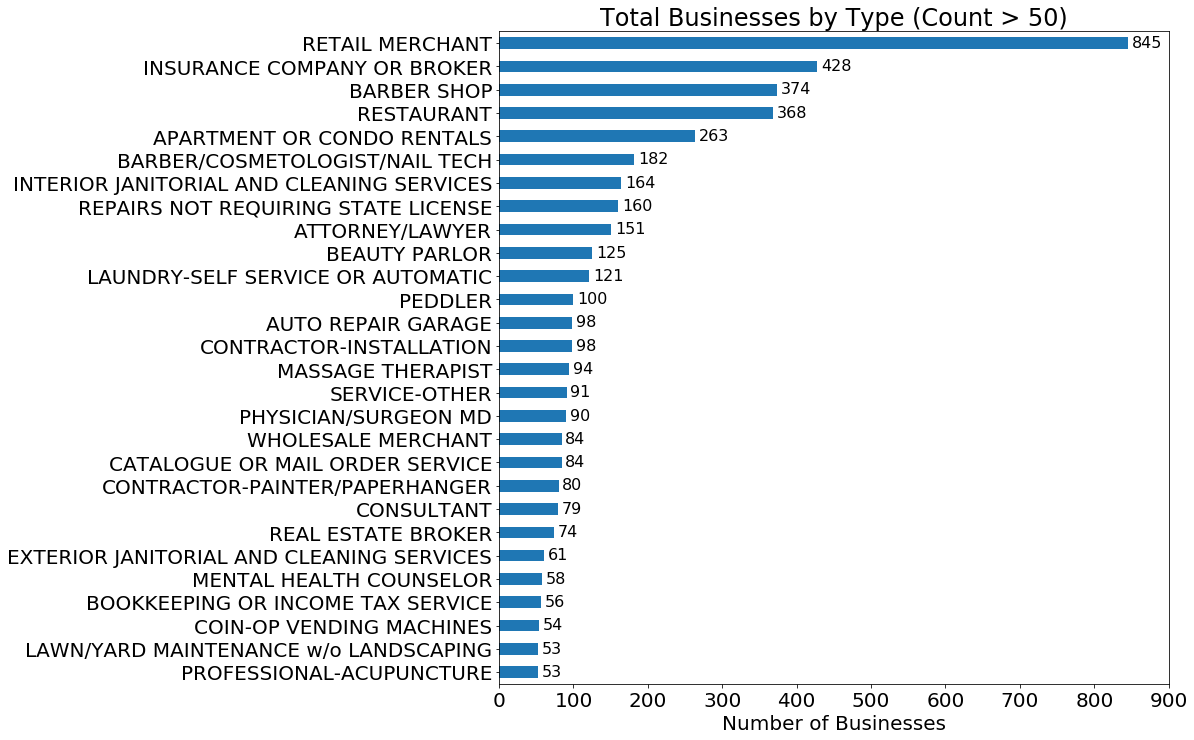

In [159]:
dglim.setFontSize(16)

fig = plt.figure()
ax = busiess_cnts[busiess_cnts > 50].plot(figsize=(12, 12), xlim=[0, 900], kind='barh', rot=0)
ax.set_xlabel('Number of Businesses')
ax.set_title('Total Businesses by Type (Count > 50)')
ax.invert_yaxis()

for p in ax.patches:
    text = str(int(p.get_width()))

    # Break long names into multiple lines
    text = '\n'.join(textwrap.wrap(text, width=20)) # why aren't you working?

    ax.text(p.get_width() + 5, p.get_y() + .55, text, size=16, rotation=0, va='bottom')

In [102]:
# Count the number of businessess classified under each NAICS type
naics_counts_df = pd.DataFrame()
naics_counts_df['NAICS Type'] = master_df['NAICS Type'].value_counts()

naics_counts_df

,NAICS Type
Retail Trade,1159
"Professional, Scientific, and Technical Services",1027
Other Services,1002
Finance & Insurance,608
Health Care and Social Assistance,587
Construction,568
Real Estate Rental and Leasing,538
Accommodation and Food Services,524
"Admin., Support, Waste Mgmt., Remediation",433
Wholesale trade,169


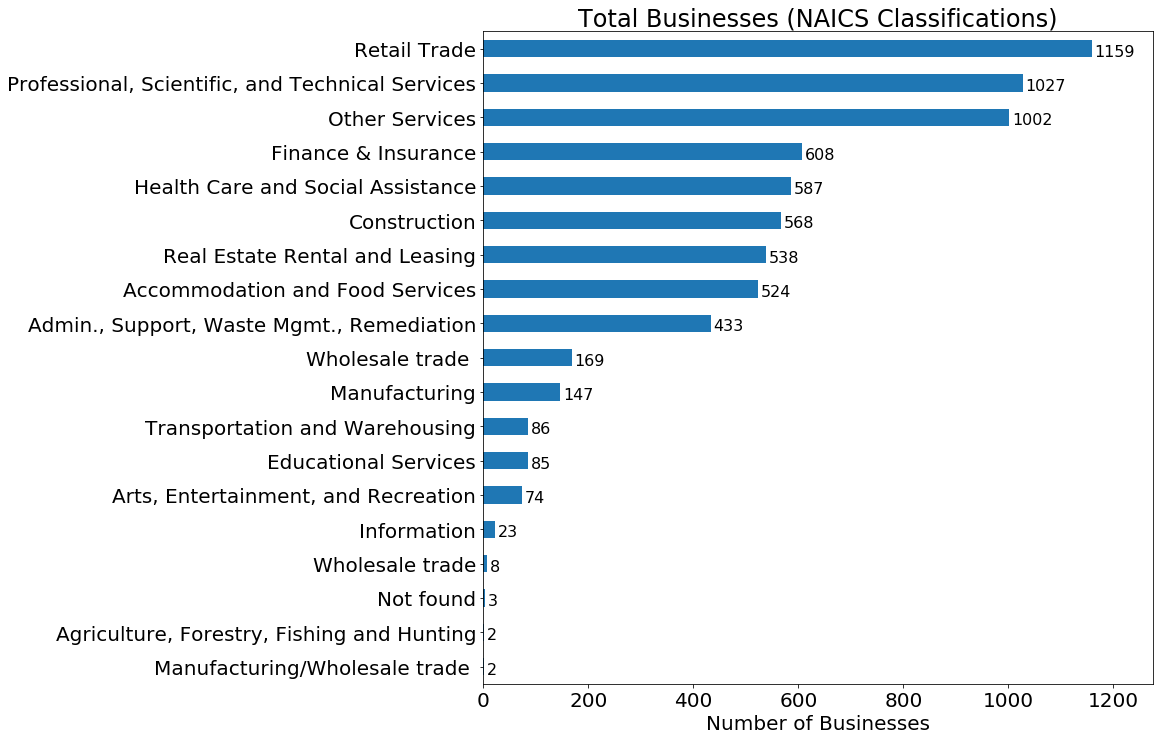

In [160]:
fig = plt.figure()
ax = naics_counts_df.plot(figsize=(12, 12), xlim=[0, 1275], kind='barh', rot=0, legend=False)
ax.set_xlabel('Number of Businesses')
#ax.set_ylabel('Business Type')
ax.invert_yaxis()

for p in ax.patches:
    text = str(int(p.get_width()))

    # Break long names into multiple lines
    text = '\n'.join(textwrap.wrap(text, width=20)) # why aren't you working?

    ax.text(p.get_width() + 5, p.get_y() + .55, text, size=16, rotation=0, va='bottom')
ax.set_title('Total Businesses (NAICS Classifications)')
fig.savefig('business_classification.png')

## Number of businesses started by year

In [8]:
act_business_df = act_business_df.assign(Start_Year = act_business_df['Start_Date'].apply(lambda x : datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p').year))

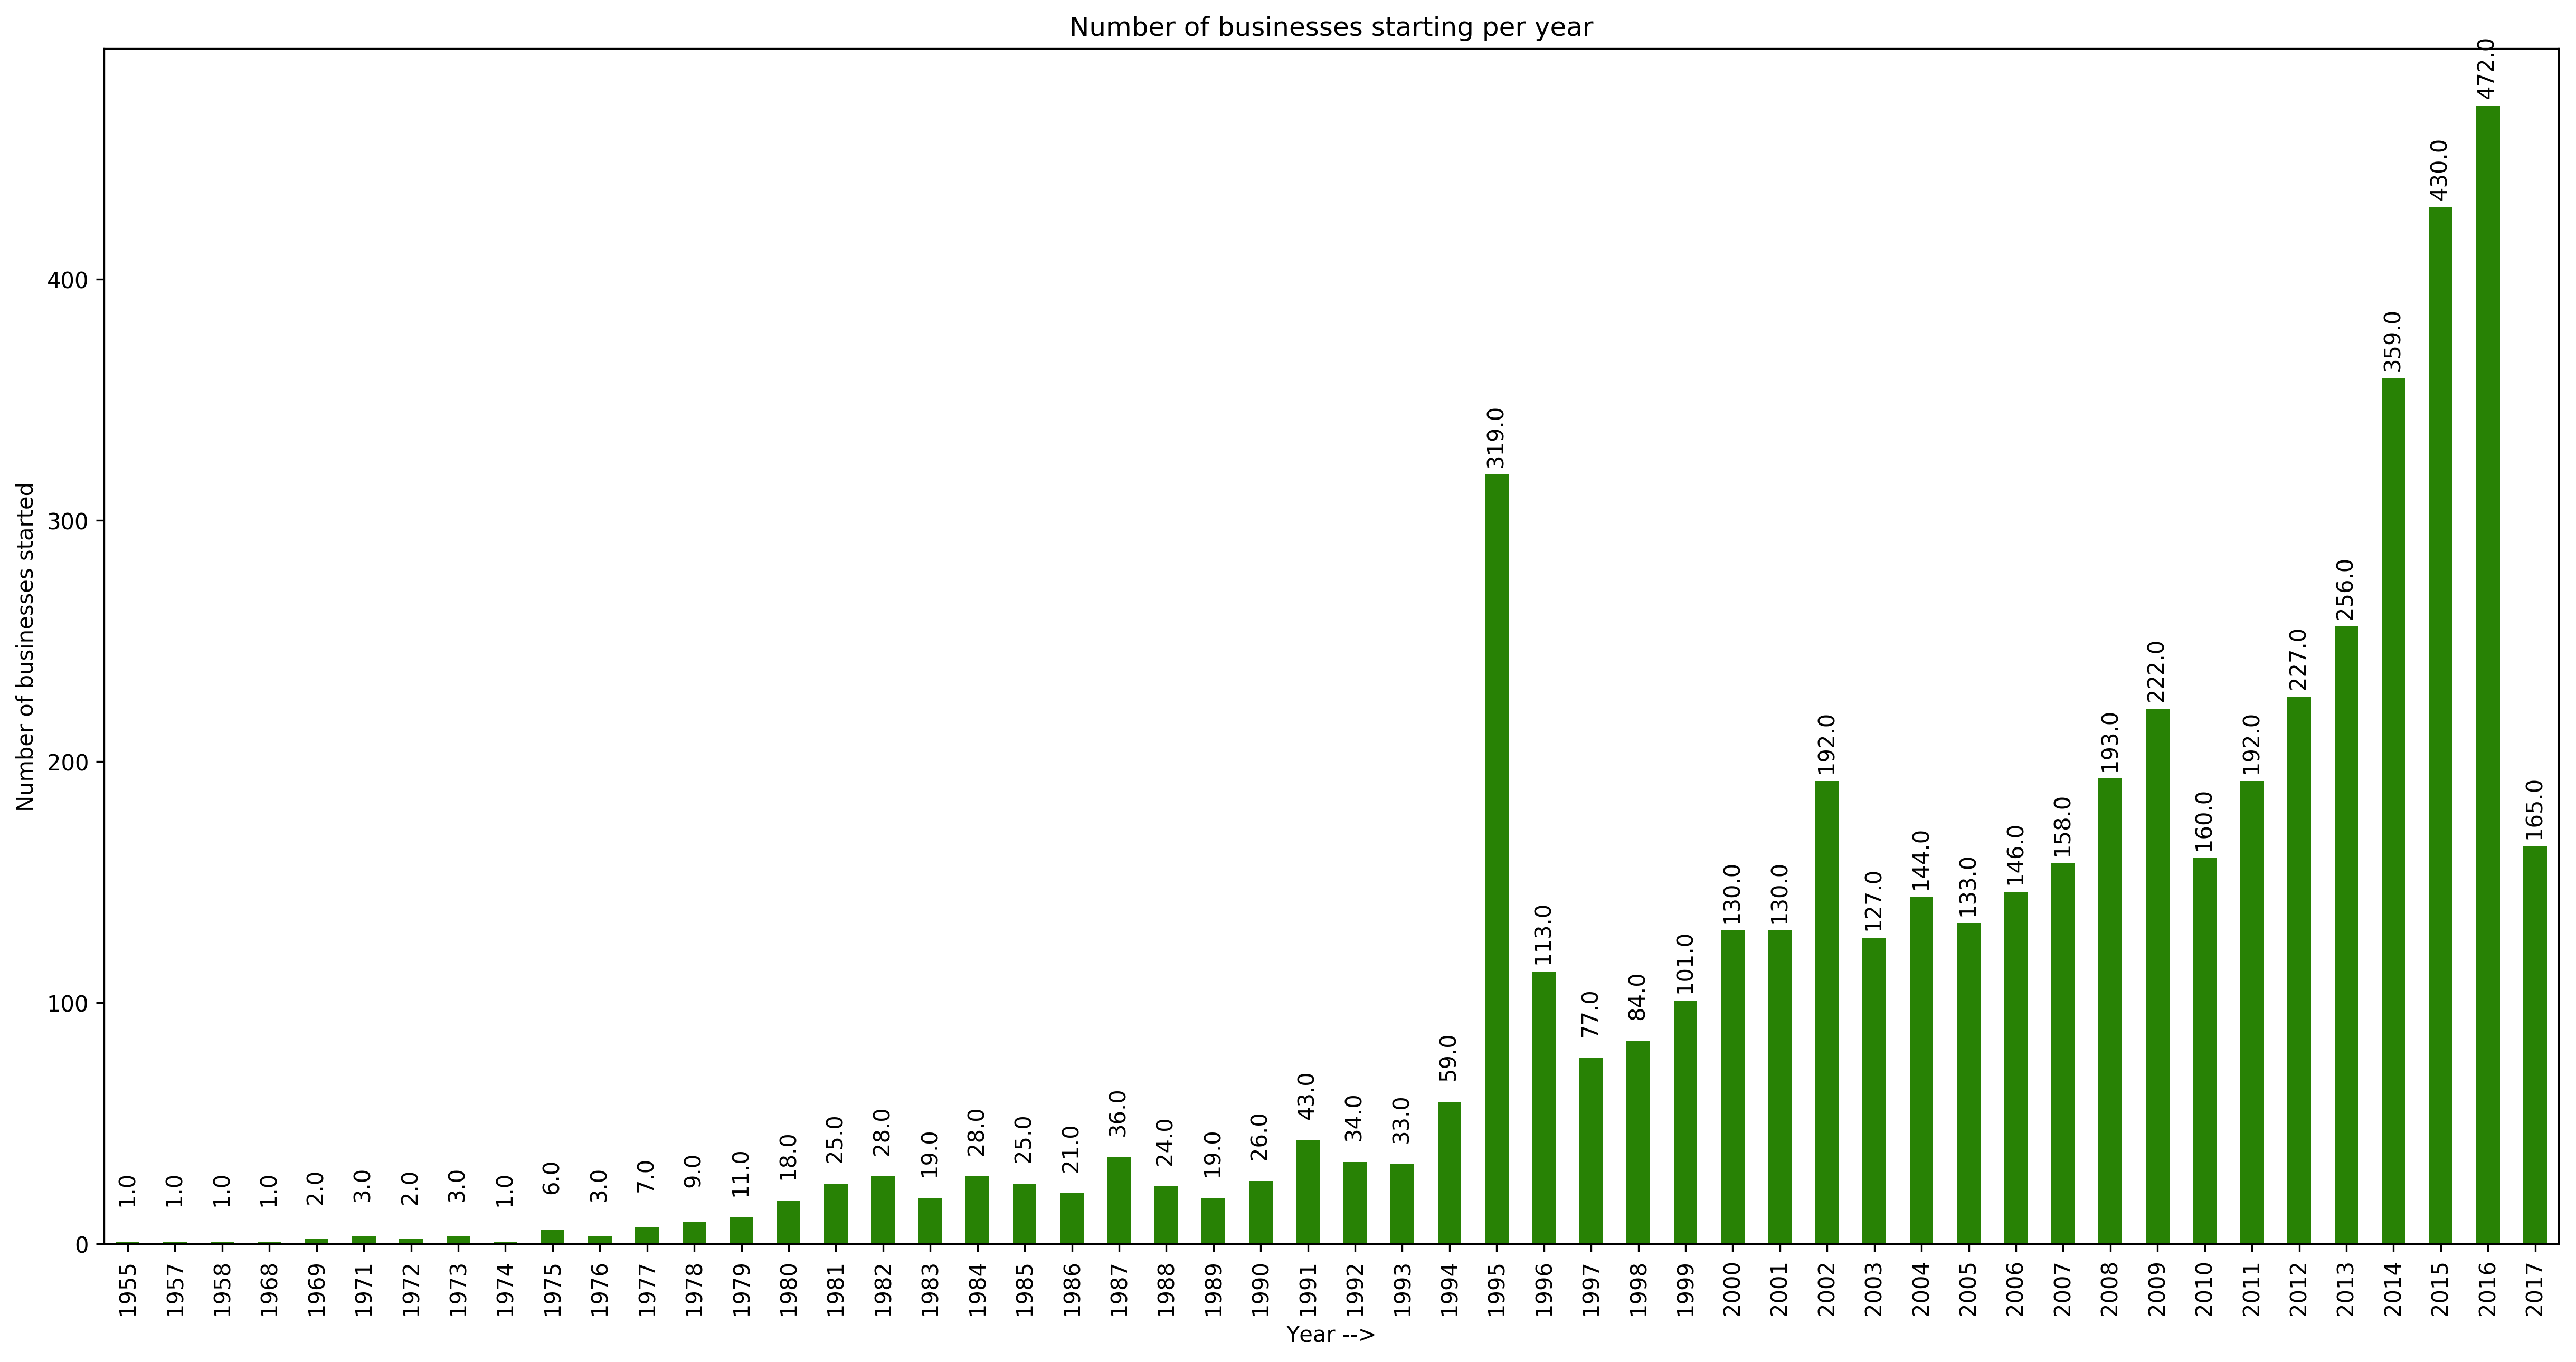

In [9]:
fig = plt.figure()
ax = act_business_df['Start_Year'].value_counts().sort_index(ascending=True).plot(figsize=(20,10), kind='bar', color='#288205')
ax.set_xlabel('Year -->')
ax.set_ylabel('Number of businesses started')
ax.set_title('Number of businesses starting per year')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()+22),rotation=90)
    
fig.savefig('business.png')

## Business distribution by region

In [11]:
class Region(Enum):
    NE = 0
    SE = 1
    SW = 2
    NW = 3
    
def getRegion(row):
    try:
        
        lat = float(row['Latitude'])
        lng = float(row['Longitude'])

        # REGION POSSIBLE VALUES
        region = Region.NE

        if(lat > 29.651961):
            if(lng < -82.325002):
                region = Region.NW
        else:
            if(lng < -82.325002):
                region = Region.SW
            else:
                region = Region.SE
        return region
    except(TypeError):
        pass
    

In [18]:
master_df[['Latitude','Longitude']].apply(getRegion, axis=1).value_counts()

Region.NW    3867
Region.SW    1280
Region.NE     951
Region.SE     946
dtype: int64

In [17]:
master_df.drop_duplicates(subset='GRU ID')[['Latitude','Longitude']].apply(getRegion, axis=1).value_counts()

Region.NW    2968
Region.SW     986
Region.SE     840
Region.NE     734
dtype: int64

In [15]:
act_business_df[['Latitude','Longitude']].apply(getRegion, axis=1).value_counts()

Region.NW    2916
Region.SW    1075
Region.NE     751
Region.SE     264
dtype: int64

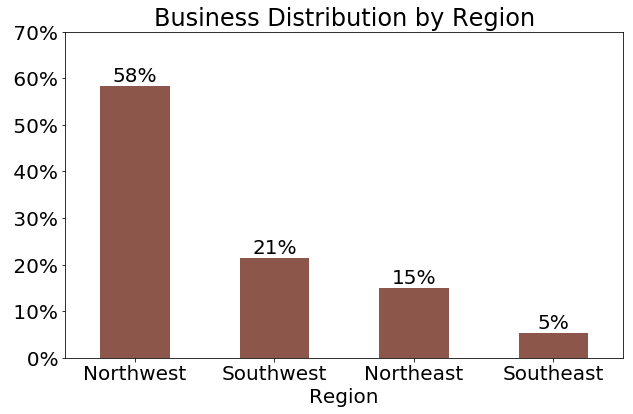

In [156]:
dglim.setFontSize(16)

data = act_business_df[['Latitude','Longitude']].apply(getRegion, axis=1)

fig = plt.figure()
ax = (data.value_counts(normalize=True)).plot(kind='bar', ylim=(0, .70), figsize=(10, 6),color='C5')
labels = ax.get_xticklabels()
labelsText = [l.get_text() for l in labels]
labelsText[0] = 'Northwest'
labelsText[1] = 'Southwest'
labelsText[2] = 'Northeast'
labelsText[3] = 'Southeast'

ax.set_xlabel('Region')
ax.set_title('Business Distribution by Region')

# Change y axis to percentages
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])

# Write percentage values
ax.set_xticklabels(labelsText, rotation = 0)
for p in ax.patches:
    ax.annotate(str(int(100 * p.get_height())) + '%', (p.get_x()+ p.get_width()/2, p.get_height() + .01), ha='center')
    # ax.annotate(str(round(100*p.get_height(), 2))+'%', (p.get_x() + p.get_width()/2, p.get_height() + .01), ha='center')

fig.savefig('Regionwise_distribution.png')

dglim.resetFontSize()

In [130]:
data.value_counts()

Region.NW    2916
Region.SW    1075
Region.NE     751
Region.SE     264
dtype: int64

In [85]:
megaDf = pd.read_csv('CSV generated Data/Collaborated Data.csv')
megaDf.set_index('Business ID',inplace=True)
megaDf

,Business Name,Business Type,Address,Start Date,Number of crimes since 2011,Permit,Permit Issue Date,Year,GRU_consumption
Business ID,,,,,,,,,
18,"AKIRA WOOD, INC.",MANUFACTURING-CABINETS,619 S MAIN ST,09/12/1995 12:00:00 AM,1444,\rPlumbing Remodel\rFire Sprinkler\rMechanical...,\r07/08/2016\r\r08/19/2016\r,\r2015\r2014\r2016\r2013\r2012\r,"\rUnknown,3783,3852,4728,5604,4662,3926,Unknow..."
20,"ALL CATS HEALTH CARE CLINIC, P.A.",VETERINARIAN,1034 NW 13TH ST,06/01/1993 12:00:00 AM,326,\rCommercial Addition\r,\r\r,\r2015\r2014\r2016\r2013\r2012\r,"\rUnknown,3311,3078,3802,3699,3889,5031,Unknow..."
46,"ARENDT, ALEKSANDRA",TAILOR,3849 SW 1ST AVE,01/28/1992 12:00:00 AM,54,\rMechanical Change Out\rReroof Shingles\r,\r05/22/2012\r06/10/2016\r,\r2015\r2014\r2016\r2013\r2012\r,"\rUnknown,459,349,394,346,702,651,Unknown,562,..."
59,"AUXIER, GLENNA",BUSINESS OFFICE NOT OTHERWISE TAXED,2815 NW 13TH CT,10/17/1993 12:00:00 AM,96,\rReRoof Shingles\r,\r08/14/2012\r,\r2015\r2014\r2016\r2013\r2012\r,"\rUnknown,927,845,1154,1182,1423,2130,Unknown,..."
110,"BOSSHARDT, CAROL R",REAL ESTATE BROKER,5542 NW 43RD ST,12/01/1992 12:00:00 AM,333,\rMechanical Change Out\r,\r04/22/2013\r,\r2015\r2014\r2016\r2013\r2012\r,"\rUnknown,4960,4580,5660,5840,6500,7800,Unknow..."
161,"LLOYD CLARKE'S RACQUET SHOPPE, INC.",RETAIL MERCHANT,1504 NW 13TH ST,09/15/1995 12:00:00 AM,1409,\rMechanical Change Out\r,\r10/02/2012\r,\r2016\r,"\r3041,2774,3171,3295,3451,4750,4930,4530,5363..."
170,COOPERATIVE LIVING,AUTO STORAGE OR PARKING LOT,117 NW 15TH ST,09/20/1995 12:00:00 AM,2475,\rBuilding Permit (No Fee)\rMechanical Remodel...,\r07/03/2013\r08/22/2013\r07/03/2013\r07/18/20...,\r2015\r2014\r2016\r2013\r2012\r,"\rUnknown,9560,8640,15440,13960,12400,16600,Un..."
181,"COOK, LEILANI C.",APARTMENT OR CONDO RENTALS,403 SW 10TH ST,09/13/1995 12:00:00 AM,1244,\rElectrical Wiring\rElectrical Wiring\rReroof...,\r07/27/2016\r08/12/2016\r08/26/2016\r,\r2015\r2014\r2016\r2013\r2012\r,"\rUnknown,147,111,117,84,43,32,Unknown,166,162..."
223,MCGURN INVESTMENT COMPANY,AUTO STORAGE OR PARKING LOT,220 SE 2ND AVE,09/26/1995 12:00:00 AM,3216,\rCommercial Remodel\rCommercial Remodel\rHood...,\r01/23/2012\r01/20/2012\r02/16/2012\r02/09/20...,\r2015\r2014\r2016\r2013\r2012\r,"\rUnknown,8949,8036,9146,9184,8599,8169,Unknow..."


In [13]:
megaDf['Business Type'].value_counts()

APARTMENT OR CONDO RENTALS                   19
RETAIL MERCHANT                               5
STORAGE WAREHOUSE OR LOT                      4
AUTO STORAGE OR PARKING LOT                   4
REAL ESTATE BROKER                            3
HOTEL, ROOMING HOUSE, MOTEL, TOUR CT.         3
LAWN/YARD MAINTENANCE w/o LANDSCAPING         3
LAUNDRY-SELF SERVICE OR AUTOMATIC             3
CATALOGUE OR MAIL ORDER SERVICE               2
TAILOR                                        2
VETERINARIAN                                  2
TRAILER/MOBILE HOME CAMPS OR PARKS            2
CONTRACTOR-INSTALLATION                       2
INTERIOR JANITORIAL AND CLEANING SERVICES     2
WHOLESALE MERCHANT                            2
PROFESSIONAL WRITER                           1
TELEPHONE COMPANY                             1
MECHANICAL CAR WASH                           1
MASSAGE THERAPIST                             1
NURSERY SCHOOL AND/OR CHILD DAYCARE           1
PHYSICAL OR SPEECH THERAPY              

## ACFR Data from acpafl.org

In [7]:
acfr_data = pd.read_csv('ACFR_Addressess.csv')

/home/asiglani/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10,11,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
acfr_data['PARCEL'].fillna("",inplace=True)

In [9]:
parcelData = acfr_data['PARCEL'].apply(lambda x : x.replace('-',''))

In [10]:
acfr_data['PARCEL'] = parcelData

In [11]:
acfr_data = acfr_data[acfr_data['CITY']=='GAINESVILLE']

In [12]:
acfr_data.head()

,X,Y,OBJECTID,FULLADDR,ROADPREDIR,ROADNAME,ROADTYPE,UNIT,CITY,STATE,...,E911TYPE,PARCEL,APR_NO,ADDRCOMMENTS,STATUS,ADDRESSPTID,last_edited_date,GlobalID,ADDRNUM,COUNTY
0,-82.387756,29.665104,13001,4104 NW 13TH PL,NW,13TH,PL,,GAINESVILLE,FL,...,SINGLE FAMILY HOUSE,06397057000,,NaN,Active,AP49467,2017-08-09T20:05:01.000Z,9e1fe8f5-f9d2-4bde-8839-c3eb7a148314,4104,ALACHUA
2,-82.350818,29.682812,13003,2042 NW 32ND PL,NW,32ND,PL,,GAINESVILLE,FL,...,SINGLE FAMILY HOUSE,08874004000,,NaN,Active,AP133058,2017-08-09T20:05:01.000Z,6cd73111-31f8-4f18-aaa4-733e39b383b7,2042,ALACHUA
4,-82.392307,29.651022,13005,4680 CLEAR LAKE DR,,CLEAR LAKE,DR,,GAINESVILLE,FL,...,SINGLE FAMILY HOUSE,06537008000,,NaN,Active,AP49469,2017-08-09T20:05:01.000Z,48cce930-8988-40a5-bc85-0a3a602c9eb5,4680,ALACHUA
5,-82.328310,29.645479,13006,708 SW 3RD ST,SW,3RD,ST,,GAINESVILLE,FL,...,SINGLE FAMILY HOUSE,13304000000,,NaN,Active,AP49470,2017-08-09T20:05:01.000Z,a1450513-f1eb-44b1-9682-140ce3434034,708,ALACHUA
6,-82.304925,29.681197,13007,1517 NE 31ST AV,NE,31ST,AVE,,GAINESVILLE,FL,...,SINGLE FAMILY HOUSE,08197008002,,NaN,Active,AP49471,2017-08-09T20:05:01.000Z,6b29ee7f-0c4f-4604-936d-a7635a985f23,1517,ALACHUA


In [13]:
permits_data = pd.read_sql('Select* FROM permit',con=cnx)

In [14]:
permits_data.head()

,id,Permit,Classification,Name,Parcel_Number,Contractor_Last_Name,Contractor_First_Name,Business,Primary_Party,Submit_Date,Issue_Date,Location,Latitude,Longitude
0,1,BP-00-00001,ReRoof Shingles,,16116023000,,,,ADD PARTY,01/03/2000,01/03/2000,"938 SE 19TH TER\nGainesville, FL\n(29.64275008...",29.64274889999999,-82.2995808
1,2,BP-03-02212,ReRoof Shingles,,09020005000,Crosier,Clayton,Crosier & Son Roofing,"LUCAS, MELANIE F",04/23/2003,04/23/2003,"1502 NW 16TH TER\nGainesville, FL\n(29.6660100...",29.6660133,-82.3436042
2,3,BP-03-03412,Gas Piping,,06014015029,NAZWORTH,BRYAN,QUALITY PLUMBING/GAINESVILLE INC,"MAE, FANNE",06/19/2003,06/19/2003,"6624 NW 27TH TER\nGainesville, FL\n(29.7155305...",29.7154825,-82.363872
3,4,BP-03-04809,ReRoof Shingles,,10618016000,MCDONALD,TRACY,TRACY MCDONALD ROOFING,"DONBIER, SHANNON M",08/21/2003,08/21/2003,"1226 NE 19TH PL\nGainesville, FL\n(29.67001078...",29.6701875,-82.3093731
4,5,BP-03-05676,"Mechanical New Commercial > $23, 000",,06550004001,WORTHMANN,THOMAS,Comfort Temp Co,THOMAS WORTHMANN,09/26/2003,09/26/2003,"621 NW 55TH ST\nGainesville, FL\n(29.658260957...",29.6582423,-82.401854


In [15]:
permits_data['Parcel_Number'] = permits_data['Parcel_Number'].replace('-','',regex=True)

### Having list of property description types

In [16]:
types_prop_desc = acfr_data['E911TYPE'].value_counts()
excel_writer = pd.ExcelWriter('Property Use Desc.xlsx')
types_prop_desc.to_excel(excel_writer,'Sheet1')
excel_writer.save()

** categories as per acpafl data **

In [17]:
business_categories = ['COMMERCIAL','COMMERCIAL (PRIMARY POINT)','HOTEL/MOTEL','TOWER (COMM)','SCHOOL - PUBLIC'
                       'BANK','CLINIC','SCHOOL - PRIVATE','NURSING HOME','GROCERY','HOSPITAL','POST OFFICE'
                       'DRUG STORE','ATM']

In [18]:
acfr_data['E911TYPE'].unique()

array(['SINGLE FAMILY HOUSE', 'MOBILE HOME', 'MULTI-FAMILY', 'NEEDS TYPE',
       'RESIDENTIAL', 'COMMERCIAL', 'UTILITY CO FACILITY',
       'SCHOOL - PUBLIC', 'TACACHALE', 'MULTI-FAMILY (PRIMARY POINT)',
       'VACANT LOT', 'CHURCH', 'RECREATIONAL/PARK',
       'COMMERCIAL (PRIMARY POINT)', 'BUS STOP', 'MISC', 'HOTEL/MOTEL',
       'UNIVERSITY OF FLORIDA', 'GOVERNMENT OFFICE', 'TOWER (COMM)',
       'GASOLINE STATION', 'DAY CARE', 'FIRE STATION', 'SCHOOL - PRIVATE',
       'POLICE STATION', 'NON LU STRUCTURE', 'BANK',
       'ACCESSORY LIVING UNIT', 'LIBRARY', 'SIGN', 'WASTE/RECYCLING',
       'WELL', 'HOSPITAL', 'GATE', 'CEMETERY', 'NURSING HOME', 'UNKNOWN',
       'POST OFFICE', 'DRUG STORE', 'GROCERY', 'POOL', 'TOWER (WATER)',
       'PLANT (WATER)', 'ALACHUA COUNTY GOVERNMENT', 'SANTA FE COLLEGE',
       'ATM', 'CLINIC', 'TENT', 'SECURITY MOBILE HOME', 'BIG BOX STORE',
       'SUBSTATION (ELEC)', 'PLANT (WASTE-WATER)', 'PLANT (POWER)',
       'CORRECTIONAL FACILITY', 'ELDER CARE'

In [19]:
commercial_addresses = acfr_data[acfr_data['E911TYPE'].isin(business_categories)]

In [20]:
permits_for_commercial = permits_data[permits_data['Parcel_Number'].isin(commercial_addresses['PARCEL'])]

In [21]:
permits_for_commercial.head()

,id,Permit,Classification,Name,Parcel_Number,Contractor_Last_Name,Contractor_First_Name,Business,Primary_Party,Submit_Date,Issue_Date,Location,Latitude,Longitude
10,11,BP-04-07325,Mechanical Change Out,Bldg K Apt 114,06511000000,Pernini,Richard,R R Pernini Inc,"CAZABELLA LLC,",10/04/2004,10/04/2004,"720 SW 34TH ST APT K119\nGainesville, FL\n(29....",29.65834409999999,-82.372404
11,12,BP-04-07327,Mechanical Change Out,Bldg K Apt 115,06511000000,Pernini,Richard,R R Pernini Inc,"CAZABELLA LLC,",10/04/2004,10/04/2004,"720 SW 34TH ST APT K120\nGainesville, FL\n(29....",29.6847379,-82.33260229999999
23,24,BP-05-09592-02,SB 7207 2 Year Permit Extension,,07882005001,WILCOX,DOUGLAS W,Scherer Construction of North Florida LLC,"NW 55TH PLACE INDUSTRIAL PARK , LLC ...",12/06/2011,12/06/2011,"1610 NW 55TH PL\nGainesville, FL\n(29.70533054...",29.70598459999999,-82.3438236
24,25,BP-06-00408,Mechanical Remodel,,12872001000,BUCKHALTER,JOHN,JOHN BUCKHALTER HEAT & AIR INC,JOHN BUCKHALTER,01/18/2006,01/18/2006,"22 SE 5TH AVE\nGainesville, FL\n(29.6471402800...",29.6472759,-82.3244589
26,27,BP-06-02644,Plumbing Remodel,Bldg I,06511000000,Pernini,Richard,R R Pernini Inc,"CAZABELLA LLC,",04/11/2006,04/11/2006,"720 SW 34TH ST\nGainesville, FL\n(29.645680338...",29.6458957,-82.3733273


In [22]:
permits_for_commercial['Permit'].count()

3007

## Finding number of businesses that have permits data

In [23]:
permits_for_commercial['Parcel_Number'].value_counts().count()

743

In [24]:
import usaddress

In [25]:
usaddress.tag('996 SW 16TH AVE')[0]

OrderedDict([('AddressNumber', u'996'),
             ('StreetNamePreDirectional', u'SW'),
             ('StreetName', u'16TH'),
             ('StreetNamePostType', u'AVE')])

In [26]:
def parseAddr(addr):
    
    try:
        addr = usaddress.tag(addr)[0]
    except:
        return [None,None,None,None]
    res = []
    addr_num=-1
    
    res.append(addr['StreetNamePreDirectional'] if 'StreetNamePreDirectional' in addr else '')
    res.append(addr['StreetName'] if 'StreetName'  in addr else '')
    res.append(addr['StreetNamePostType'] if 'StreetNamePostType'  in addr else '')
    if 'AddressNumber' in addr:
        try:
            addr_num = int(addr['AddressNumber'])
            res.append(addr_num)
        except ValueError:
            res.append(-1)
    else:
        res.append(-1)
    
    return res

In [27]:
parsedAddresses = list(act_business_df['Address'].apply(parseAddr))

In [28]:
parsedAddresses_df = pd.DataFrame(parsedAddresses,columns=['ROADPREDIR','ROADNAME','ROADTYPE','ADDRNUM'])
parsedAddresses_df.head()

,ROADPREDIR,ROADNAME,ROADTYPE,ADDRNUM
0,NE,21ST,WAY,2948.0
1,NW,6TH,ST,2225.0
2,NW,53RD,AVE,1001.0
3,NE,19TH,DR,3003.0
4,NW,13TH,ST,1201.0


In [29]:
act_business_df = pd.concat([act_business_df, parsedAddresses_df],axis=1)
act_business_df.head()

,id,Business_Type,Name,Start_Date,Address,Latitude,Longitude,ROADPREDIR,ROADNAME,ROADTYPE,ADDRNUM
0,1,AUTO REPAIR GARAGE,"AUTOMOTIVE ELECTRIC SPECIALIST LLC, A",11/01/1991 12:00:00 AM,2948 NE 21ST WAY,29.68,-82.29527829999999,NE,21ST,WAY,2948.0
1,2,RETAIL MERCHANT,"ALL TYPE VACUUM CTR, INC",09/14/1995 12:00:00 AM,2225 NW 6TH ST,29.6737,-82.3305485,NW,6TH,ST,2225.0
2,3,STORAGE WAREHOUSE OR LOT,A-TURNER MVG. & STG. INC.,01/22/1996 12:00:00 AM,1001 NW 53RD AVE,29.7023,-82.335663,NW,53RD,AVE,1001.0
3,4,REPAIRS NOT REQUIRING STATE LICENSE,"A-1 HANDYMAN, INC.",05/01/1978 12:00:00 AM,"3003 NE 19TH DR, STE. 8",29.6801,-82.2977954,NE,19TH,DR,3003.0
4,5,TRAVEL AGENCY,"AUTO CLUB GROUP INC, THE",09/27/1995 12:00:00 AM,1201 NW 13TH ST,29.6633,-82.3386237,NW,13TH,ST,1201.0


In [30]:
act_business_df.count()

id               5019
Business_Type    5019
Name             5019
Start_Date       5019
Address          5019
Latitude         5006
Longitude        5006
ROADPREDIR       5016
ROADNAME         5016
ROADTYPE         5016
ADDRNUM          5016
dtype: int64

In [31]:
act_business_df.columns

Index([           u'id', u'Business_Type',          u'Name',    u'Start_Date',
             u'Address',      u'Latitude',     u'Longitude',    u'ROADPREDIR',
            u'ROADNAME',      u'ROADTYPE',       u'ADDRNUM'],
      dtype='object')

In [32]:
bus_with_parcel = pd.merge(acfr_data,act_business_df,how='inner',on=['ADDRNUM','ROADPREDIR','ROADNAME','ROADTYPE'])

In [33]:
bus_with_parcel.head()

,X,Y,OBJECTID,FULLADDR,ROADPREDIR,ROADNAME,ROADTYPE,UNIT,CITY,STATE,...,GlobalID,ADDRNUM,COUNTY,id,Business_Type,Name,Start_Date,Address,Latitude,Longitude
0,-82.326403,29.669673,13025,1901 NW 2ND ST - APT M1,NW,2ND,ST,APT M1,GAINESVILLE,FL,...,39f3c9ce-0f4f-4c9a-b234-e854154bc98e,1901,ALACHUA,769,LAUNDRY-SELF SERVICE OR AUTOMATIC,"WASHCO LAUNDRY EQUIPMENT, INC./SUNSHINE",09/27/1995 12:00:00 AM,1901 NW 2ND ST,29.6693,-82.32565199999999
1,-82.325474,29.669133,13862,1901 NW 2ND ST - APT F6,NW,2ND,ST,APT F6,GAINESVILLE,FL,...,c3267fd1-026b-4873-b54c-aa7e6c16374c,1901,ALACHUA,769,LAUNDRY-SELF SERVICE OR AUTOMATIC,"WASHCO LAUNDRY EQUIPMENT, INC./SUNSHINE",09/27/1995 12:00:00 AM,1901 NW 2ND ST,29.6693,-82.32565199999999
2,-82.326356,29.669674,9613,1901 NW 2ND ST - APT M2,NW,2ND,ST,APT M2,GAINESVILLE,FL,...,5a80fb36-11cc-4c1a-8568-d94c52db7f5f,1901,ALACHUA,769,LAUNDRY-SELF SERVICE OR AUTOMATIC,"WASHCO LAUNDRY EQUIPMENT, INC./SUNSHINE",09/27/1995 12:00:00 AM,1901 NW 2ND ST,29.6693,-82.32565199999999
3,-82.326124,29.669673,15224,1901 NW 2ND ST - APT M5,NW,2ND,ST,APT M5,GAINESVILLE,FL,...,14bccb6c-618c-463c-937f-297257223721,1901,ALACHUA,769,LAUNDRY-SELF SERVICE OR AUTOMATIC,"WASHCO LAUNDRY EQUIPMENT, INC./SUNSHINE",09/27/1995 12:00:00 AM,1901 NW 2ND ST,29.6693,-82.32565199999999
4,-82.326314,29.669672,15788,1901 NW 2ND ST - APT M3,NW,2ND,ST,APT M3,GAINESVILLE,FL,...,81d078fc-a57a-4a60-84c3-8bc5efec5522,1901,ALACHUA,769,LAUNDRY-SELF SERVICE OR AUTOMATIC,"WASHCO LAUNDRY EQUIPMENT, INC./SUNSHINE",09/27/1995 12:00:00 AM,1901 NW 2ND ST,29.6693,-82.32565199999999


#### Unique number of businesses with parcel info

In [34]:
len(bus_with_parcel['id'].value_counts())

4537

In [35]:
bus_with_parcel[bus_with_parcel['PARCEL'] == '06053007000']['id'].value_counts()

4037    302
2692    302
4617    302
4604    302
365     302
212     302
Name: id, dtype: int64

In [36]:
parcel_nums = list(bus_with_parcel['PARCEL'].value_counts().index)

** Creating dictionary of form {Business ID : Parcel Number} **

In [37]:
bID_parcel_dict = {}
for p in parcel_nums:
        bid_list = list(bus_with_parcel[bus_with_parcel['PARCEL'] == p]['id'].value_counts().index)
        for bid in bid_list:
            bID_parcel_dict[bid-1] = p

### Adding None to non existant parcel numbers

In [38]:
for i in df.index:
    if(i not in bID_parcel_dict):
        bID_parcel_dict[i] = None

In [39]:
print bID_parcel_dict[5018]

06064050009


In [40]:
parcel_data = pd.Series(bID_parcel_dict)

In [41]:
df['Parcel'] = parcel_data

In [42]:
df.head()

,id,Business_Type,Name,Start_Date,Address,Latitude,Longitude,Parcel
0,1,AUTO REPAIR GARAGE,"AUTOMOTIVE ELECTRIC SPECIALIST LLC, A",11/01/1991 12:00:00 AM,2948 NE 21ST WAY,29.68,-82.29527829999999,08199031000
1,2,RETAIL MERCHANT,"ALL TYPE VACUUM CTR, INC",09/14/1995 12:00:00 AM,2225 NW 6TH ST,29.6737,-82.3305485,09289000000
2,3,STORAGE WAREHOUSE OR LOT,A-TURNER MVG. & STG. INC.,01/22/1996 12:00:00 AM,1001 NW 53RD AVE,29.7023,-82.335663,07966010004
3,4,REPAIRS NOT REQUIRING STATE LICENSE,"A-1 HANDYMAN, INC.",05/01/1978 12:00:00 AM,"3003 NE 19TH DR, STE. 8",29.6801,-82.2977954,08199047000
4,5,TRAVEL AGENCY,"AUTO CLUB GROUP INC, THE",09/27/1995 12:00:00 AM,1201 NW 13TH ST,29.6633,-82.3386237,09536001000


In [43]:
df.to_csv('Active_Businesses_with_parcel.csv')

## Creating complete data grid

In [141]:
def boolToNum(bool_val):
    return 1 if bool_val else 0

#### Checking if permits data exists

In [142]:
df['Has_Permits_Data'] = df['Parcel'].isin(permits_data['Parcel_Number']).apply(boolToNum)

In [143]:
df['Has_Permits_Data'].value_counts()

0    3146
1    1873
Name: Has_Permits_Data, dtype: int64

#### Checking if commercial zoning data exists

In [116]:
comm_zoning_df = pd.read_excel('./City_Data/CSV_Files/commercial zoning violations.xls')

In [117]:
comm_zoning_df.head()

,Number,Violation,Case Type,Infraction,Parcel,Address
0,CE-15-02841,Sanitation - Commercial,ZONING_C - Commercial Zoning Violations,2015-11-23,16107150000,01515 SE 8TH PL
1,CE-15-02842,Sanitation - Commercial,ZONING_C - Commercial Zoning Violations,2015-11-23,16106129000,01021 SE 15TH ST
2,CE-11-01679,Permitted Use,ZONING_C - Commercial Zoning Violations,2011-06-11,16106020000,01521 SE 12TH AVE
3,CE-11-01610,NaN,ZONING_C - Commercial Zoning Violations,2011-06-03,15975001000,00922 SE WILLISTON RD
4,CE-11-01541,NaN,ZONING_C - Commercial Zoning Violations,2011-05-25,15954024000,01038 SE 3RD ST


In [121]:
comm_zoning_df['Parcel'] = comm_zoning_df['Parcel'].apply(str)

In [144]:
df['Has_commercial_zoning_data'] = df['Parcel'].isin(comm_zoning_df['Parcel']).apply(boolToNum)

In [145]:
df['Has_commercial_zoning_data'].value_counts()

0    4881
1     138
Name: Has_commercial_zoning_data, dtype: int64

#### Checking if commercial building code violations data exists

In [126]:
build_code_vio_df = pd.read_excel('./City_Data/CSV_Files/commercial building code violations.xls')

In [128]:
build_code_vio_df['Parcel'] = build_code_vio_df['Parcel'].apply(str)

In [146]:
df['Has_code_vio_data'] = df['Parcel'].isin(build_code_vio_df['Parcel']).apply(boolToNum)

In [147]:
df['Has_code_vio_data'].value_counts()

0    4843
1     176
Name: Has_code_vio_data, dtype: int64

In [135]:
df.columns

Index([                        u'id',              u'Business_Type',
                             u'Name',                 u'Start_Date',
                          u'Address',                   u'Latitude',
                        u'Longitude',                     u'Parcel',
                 u'Has_Permits_Data', u'Has_commercial_zoning_data',
                u'Has_code_vio_data'],
      dtype='object')

In [139]:
data_grid_df = df[['id','Name','Address','Business_Type','Has_Permits_Data','Has_commercial_zoning_data','Has_code_vio_data']]
excel_writer = pd.ExcelWriter('data_grid.xlsx')
data_grid_df.to_excel(excel_writer,'Sheet1')
excel_writer.save()

In [159]:
data_num_count = (df['Has_code_vio_data'] + df['Has_commercial_zoning_data'] + df['Has_Permits_Data']).sort_values(ascending=False)

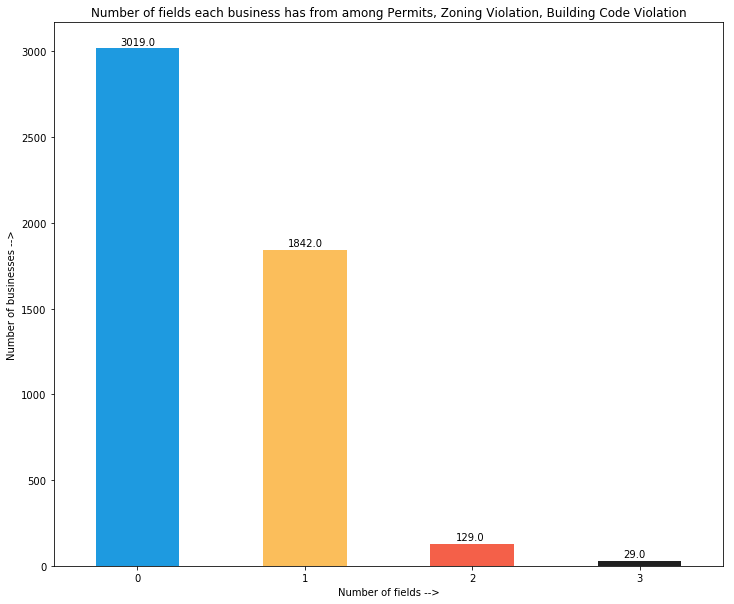

In [204]:
fig = plt.figure()
ax = data_num_count.value_counts().plot(figsize=(12,10),kind='bar',stacked=True,
                                        color=[('#1e9ae0','#fbbe5b','#f46049','#202020')])
labels = ax.get_xticklabels()
labelsText = [l.get_text() for l in labels]
labelsText[0] = '0'
labelsText[1] = '1'
labelsText[2] = '2'
labelsText[3] = '3'

ax.set_xlabel('Number of fields -->')
ax.set_ylabel('Number of businesses -->')
ax.set_title('Number of fields each business has from among Permits, Zoning Violation, Building Code Violation')

ax.set_xticklabels(labelsText, rotation = 0)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.15, p.get_height()+20),rotation=0)

fig.savefig('data_distribution.png')

In [231]:
demo_df = pd.DataFrame(df['Has_Permits_Data'].value_counts())
# demo_df[]
demo_df['Has_code_vio_data'] = df['Has_code_vio_data'].value_counts()
demo_df['Has_commercial_zoning_data'] = df['Has_commercial_zoning_data'].value_counts()

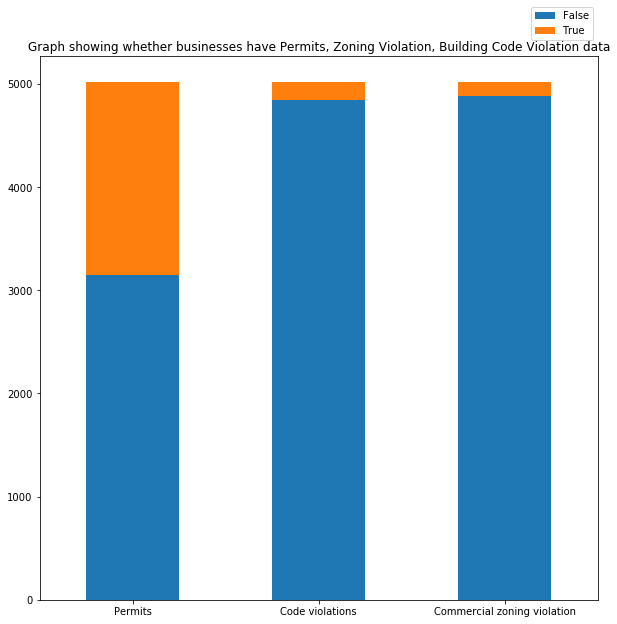

In [259]:
fig = plt.figure()

ax = demo_df.transpose().plot.bar(stacked=True, figsize=(10,10))
ax.set_xticklabels(['Permits','Code violations','Commercial zoning violation'],rotation=0)
ax.legend(['False','True'],bbox_to_anchor=(1, 1.1))
ax.set_title('Graph showing whether businesses have Permits, Zoning Violation, Building Code Violation data')

fig.savefig('boolean_data.png')

### Writing Data frame to SQL Table

In [319]:
from sqlalchemy import create_engine

In [322]:
engine = create_engine('mysql+mysqldb://root@127.0.0.1/DGLIM_Data')

In [2]:
df.to_sql('DEMO',con=engine,if_exists='replace',index=False)

NameError: name 'df' is not defined